# BNN loading and testing

### Load the BNN

First we import the relevant libraries and set the working directory

In [1]:
import torch
from torchvision import datasets, transforms
import pickle as pickle

In [23]:
import os
import sys

# Get current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

# Add parent directory to Python path
parent_dir = os.path.dirname(cwd)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

Current working directory: /Users/conor/Desktop/Thesis-Minimised/my-experiments


The cell below can be used to reload the BNN code if it has been changed

In [55]:
import importlib # Import the importlib module
import BNN

from BNN.models import MLP
from BNN.wrapper import BNN_cat
from BNN.train import train_BNN_classification

importlib.reload(BNN.models)  # Contains MLP
importlib.reload(BNN.wrapper) # Contains BNN_cat
importlib.reload(BNN.train)  # Contains train_BNN_classification

from BNN.models import MLP
from BNN.wrapper import BNN_cat
from BNN.train import train_BNN_classification

Next we load the BNN model

In [57]:
%matplotlib inline

input_dim = 784
width = 1200
depth = 2
output_dim = 10
model = MLP(input_dim, width, depth, output_dim, flatten_image=False)

N_train = 60000

lr = 1e-2

# N_saves = 300
N_saves = 5

BNN = BNN_cat(model, N_train, lr=lr)
# Move BNN to CPU
print(BNN.device)

save_dir = '../my-saves/'
weights_path = save_dir + 'state_dicts.pt'

if os.path.exists(weights_path):
    BNN.load_weights(weights_path)
else:
    print(f"Weights file not found at: {weights_path}")



Net:
BNN categorical output


    Total params: 2.40M
mps
Loading weight samples from ../my-saves/state_dicts.pt
File size: 2741.68 MB
Loaded object type: <class 'list'>
Number of weight samples: 300


Load the datasets


In [5]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    #     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

batch_size = 1024

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=BNN.device.type == 'cuda', num_workers=3)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=BNN.device.type == 'cuda', num_workers=3)

### Test the BNN


#### Testing the predictive performance
Next we test the BNN on a few random samples from the test set. We also plot the true and predicted labels, as well as the predicted probabilities for each class.
The "relative loss" is the loss for each prediction min-max scaled over the sampled predictions. It is used to highlight the samples for which the BNN performs poorly.

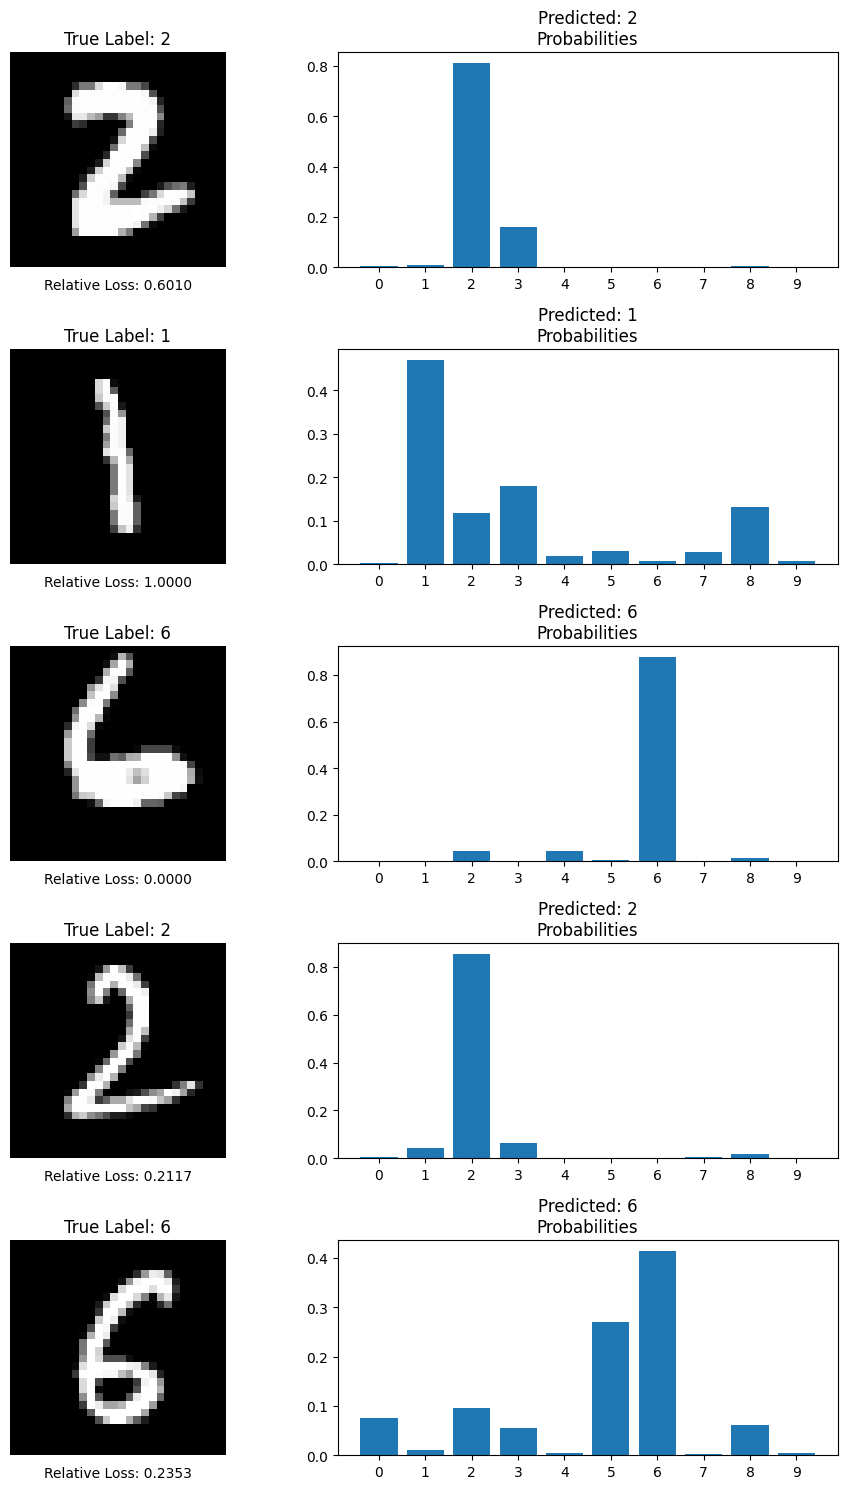

In [40]:
import matplotlib.pyplot as plt
import random

# Get a few test samples
dataiter = iter(valloader)
images, labels = next(dataiter)

# Move images to the same device as the model
images = images.to(BNN.device)

# Flatten the images
images = images.view(images.size(0), -1)  # Flatten each image to a 1D tensor

# Select random 5 samples
n_samples = 5
indices = random.sample(range(len(images)), n_samples)
images = images[indices]
labels = labels[indices]

# Get predictions from BNN with multiple samples
n_pred_samples = 30  # Align with working code
probs = BNN.sample_predict(images.view(n_samples, -1), Nsamples=n_pred_samples)
mean_probs = probs.mean(dim=0)
pred_labels = mean_probs.argmax(dim=1)

# Calculate losses for all samples first
losses = []
for i in range(n_samples):
    image_input = images[i].view(1, -1).to(BNN.device)
    label_input = labels[i].view(1).to(BNN.device)
    loss, _, _ = BNN.eval(image_input, label_input)
    losses.append(loss.item())

# Min-max scale the losses
min_loss = min(losses)
max_loss = max(losses)
scaled_losses = [(loss - min_loss) / (max_loss - min_loss) if max_loss != min_loss else 0 for loss in losses]

# Plot results
fig, axes = plt.subplots(n_samples, 2, figsize=(10, 3*n_samples))
for i in range(n_samples):
    # Plot original image
    axes[i, 0].imshow(images[i].cpu().view(28, 28), cmap='gray')
    axes[i, 0].set_title(f'True Label: {labels[i].item()}')
    axes[i, 0].axis('off')
    
    # Add scaled loss text below the image
    axes[i, 0].text(0.5, -0.1, f'Relative Loss: {scaled_losses[i]:.4f}', 
                    horizontalalignment='center',
                    transform=axes[i, 0].transAxes)

    # Plot prediction probabilities
    probs = mean_probs[i].cpu().detach().numpy()
    axes[i, 1].bar(range(10), probs)
    axes[i, 1].set_title(f'Predicted: {pred_labels[i].item()}\nProbabilities')
    axes[i, 1].set_xticks(range(10))

plt.tight_layout()
plt.show()


#### Testing the uncertainty estimates
Next we're going to evaluate the uncertainty estimates of the BNN. We'll use the entropy decomposition method. We also calculate the sample disagreement uncertainty.

In [59]:
# Get all test samples
images_list = []
labels_list = []
for images, labels in valloader:
    # Move images to the same device as the model
    images = images.to(BNN.device)
    
    # Flatten the images
    images = images.view(images.size(0), -1)  # Flatten each image to a 1D tensor
    
    images_list.append(images)
    labels_list.append(labels)

# Concatenate all batches
images = torch.cat(images_list, dim=0)
labels = torch.cat(labels_list, dim=0)

# Get predictions from BNN with multiple samples
n_pred_samples = 100  # Align with working code
probs = BNN.sample_predict(images.view(images.size(0), -1), Nsamples=n_pred_samples)

# Evaluate the uncertainty
total_correlation, aleatoric_correlation, epistemic_correlation, sample_correlation, combined_correlation = BNN.evaluate_uncertainty(probs, labels)
print(f"Total Correlation: {total_correlation:.4f}")
print(f"Aleatoric Correlation: {aleatoric_correlation:.4f}")
print(f"Epistemic Correlation: {epistemic_correlation:.4f}")
print(f"Sample Correlation: {sample_correlation:.4f}")
print(f"Combined Correlation: {combined_correlation:.4f}")

Total Correlation: 0.2641
Aleatoric Correlation: 0.2630
Epistemic Correlation: 0.1877
Sample Correlation: 0.3688
Combined Correlation: 0.3150
